# Results from binary classification

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
%matplotlib inline

## Importing shapefiles

First thing we do is to import the NUTS 3 level shapefiles from Eurostat, available at [Eurostat](https://ec.europa.eu/eurostat/web/gisco/geodata/reference-data/administrative-units-statistical-units/nuts#nuts21).

In [105]:
gdf_nuts3 = gpd.read_file(
    'data/NUTS_RG_01M_2021_3857_LEVL_3.shp.zip',
    crs = "EPSG:4326"
)

In [106]:
# Filter out all countries except Norway
gdf_NOnuts3 = gdf_nuts3[gdf_nuts3.CNTR_CODE.str.contains('NO')]
# We manually filter out Svalbard and Jan Mayen as we are not interested in them
gdf_NOnuts3 = gdf_NOnuts3.query('FID != "NO0B1" and FID != "NO0B2"')
# Return to sequential index from 0 to 13
gdf_NOnuts3 = gdf_NOnuts3.reset_index()
# Set the coordinate reference system to EPSG:4326 - same as our twitter data. 
gdf_NOnuts3 = gdf_NOnuts3.to_crs("EPSG:4326")

## Twitter data

We start by simply loading the data from our csv file

In [112]:
df_twitter = pd.read_csv(
    "complete_datset_f1083_noemoji.csv",
    parse_dates=[
        'created_at'
    ]
)

### Temporal analysis

In [113]:
df_twitter_monthly = pd.DataFrame(df_twitter.copy())

In [114]:
df_twitter_monthly.index = df_twitter_monthly[
    'created_at'
].dt.to_period(
    'M'
)

/home/oskar/miniconda3/envs/oskar/lib/python3.10/site-packages/pandas/core/arrays/datetimes.py:1162: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


<AxesSubplot:title={'center':'Number of tweets over time'}, xlabel='Year', ylabel='Number of tweets'>

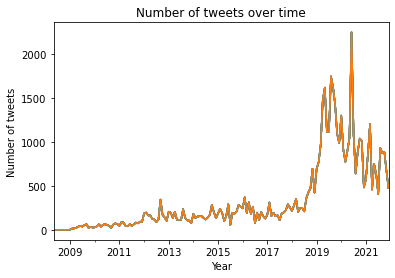

In [116]:
df_twitter_monthly.groupby(
    level=0
).count(
).plot(
    xlabel = 'Year',
    ylabel = 'Number of tweets',
    legend = None,
    title = 'Number of tweets over time'
)

### With sentiment scores
We then caluclate the sentiment score and do analysis. In the binary classification, 0 = negative and 1 = non-negative

In [117]:
df_twitter_monthly_senti = pd.DataFrame(df_twitter.copy())

In [118]:
df_twitter_monthly_senti.index = df_twitter_monthly_senti['created_at'].dt.to_period('M')

/home/oskar/miniconda3/envs/oskar/lib/python3.10/site-packages/pandas/core/arrays/datetimes.py:1162: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


In [119]:
# We first calculate the total number of values for each months
total_sentiments = df_twitter_monthly_senti.groupby(level=0).count()
total_sentiments

,Unnamed: 0,username,text,loc,created_at,like_count,quote_count,latitude,longitude,label,logits0,logits1
created_at,,,,,,,,,,,,
2008-05,1,1,1,1,1,1,1,1,1,1,1,1
2008-08,1,1,1,1,1,1,1,1,1,1,1,1
2008-09,3,3,3,3,3,3,3,3,3,3,3,3
2008-11,2,2,2,2,2,2,2,2,2,2,2,2
2008-12,1,1,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08,930,930,930,930,930,930,930,930,930,930,930,930
2021-09,873,873,873,873,873,873,873,873,873,873,873,873
2021-10,883,883,883,883,883,883,883,883,883,883,883,883


In [121]:
# then next, we calculate the sum of the label values, which will correspond to the total amount of non-negative tweets
average_sentiments = df_twitter_monthly_senti.groupby(level=0).sum()
average_sentiments

,Unnamed: 0,username,like_count,quote_count,latitude,longitude,label,logits0,logits1
created_at,,,,,,,,,
2008-05,7,1477,0,0.0,59.902747,5.298615,1,-1.842539,1.935644
2008-08,6,7092,0,0.0,59.913330,10.738970,1,-2.078634,2.372182
2008-09,12,8607,0,0.0,179.729408,26.776555,3,-3.726587,3.872514
2008-11,3,12826,0,0.0,120.788611,10.651838,1,-0.867761,0.314874
2008-12,0,7092,0,0.0,59.913330,10.738970,1,-0.419717,-0.100642
...,...,...,...,...,...,...,...,...,...
2021-08,47604375,4605787,2273,39.0,56366.056829,8940.367688,600,-716.110295,423.488053
2021-09,45473697,4379288,2962,52.0,52869.278491,8382.193962,554,-653.676461,351.760111
2021-10,46769861,4361186,3226,40.0,53645.672907,8703.176195,586,-635.753535,391.153683


In [122]:
# 1 = positive, 0 = negative 
# the amount of negative sentiments is calculated by the total amount of sentiments minus the amount of non-negative
# the amount of non-negative is calculated before
df_twitter_monthly_senti['negative_sentiment'] = total_sentiments['label'] - average_sentiments['label']
df_twitter_monthly_senti['non-negative_sentiment'] = average_sentiments['label']

In [123]:
df_twitter_monthly_senti.head(10)

,Unnamed: 0,username,text,loc,created_at,like_count,quote_count,latitude,longitude,label,logits0,logits1,negative_sentiment,non-negative_sentiment
created_at,,,,,,,,,,,,,,
2008-12,0,7092,NYHET: Vil heller ha vindkraft http://tinyurl....,Oslo,2008-12-08 07:25:53+00:00,0,0.0,59.913330,10.738970,1,-0.419717,-0.100642,0,1
2008-11,1,6413,Vindkraft som mulighet\n: \n Vindmølleparker v...,Bergen,2008-11-25 05:33:07+00:00,0,0.0,60.394306,5.325919,0,-0.102788,-0.169470,1,1
2008-11,2,6413,Vil spreie vindturbinar over halve kommunen\n:...,Bergen,2008-11-18 09:33:01+00:00,0,0.0,60.394306,5.325919,1,-0.764973,0.484344,1,1
2008-09,3,1477,Fitjar med i kamp om vindm&oslash;lle-milliard...,Fitjar,2008-09-17 16:51:10+00:00,0,0.0,59.902747,5.298615,1,-2.059849,2.241215,0,3
2008-09,4,1431,har lyst på eget vindkraftverk: http://www.hom...,Oslo,2008-09-06 10:16:18+00:00,0,0.0,59.913330,10.738970,1,-1.576066,1.471449,0,3
2008-09,5,5699,alec baldwin: hvis jeg hadde utsikt til vindmø...,Oslo,2008-09-03 18:58:52+00:00,0,0.0,59.913330,10.738970,1,-0.090673,0.159850,0,3
2008-08,6,7092,NYHET: Ti prosent vindkraft i 2015 http://tiny...,Oslo,2008-08-26 05:35:47+00:00,0,0.0,59.913330,10.738970,1,-2.078634,2.372182,0,1
2008-05,7,1477,Optimisme i h&oslash;ve til &oslash;konomien: ...,Fitjar,2008-05-30 13:53:27+00:00,0,0.0,59.902747,5.298615,1,-1.842539,1.935644,0,1
2009-05,8,8837,"RT @stalesunde Når forandringens vind blåser, ...",Kristiansand,2009-05-31 09:06:51+00:00,0,0.0,58.085628,7.931858,1,-0.641155,0.167813,11,28


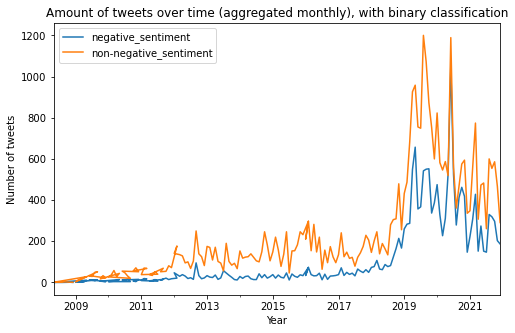

In [127]:
df_twitter_monthly_senti.plot(
    xlabel = 'Year',
    y = ['negative_sentiment','non-negative_sentiment'],
    ylabel = 'Number of tweets',
    legend = True,
    figsize = (8,5),
    title = 'Amount of tweets over time (aggregated monthly), with binary classification'
)
plt.savefig('figures/tweets_over_time_monthly_agg.png')

### Spatial analysis

In [19]:
# Transform the twitter data it into a GeoDataFrame with point geometry based on longitude and latitude.
gdf_twitter = gpd.GeoDataFrame(
    df_twitter,
    crs = "EPSG:4326",
    geometry=gpd.points_from_xy(
        df_twitter.longitude, 
        df_twitter.latitude
    )
)

In [20]:
gdf_twitter = gdf_twitter.rename(
    columns={
        "loc": "city"
    }
)

In [21]:
# Create a new list with one row for each city
gdf_twitter_grouped = gdf_twitter[gdf_twitter.city != "Longyearbyen"]
gdf_twitter_grouped = gdf_twitter.groupby(
    'city'
).first(
)

In [22]:
# Add a new column 'twitter_frequency' with the number of times each city occur.
# This amounts to the twitter frequency.
gdf_twitter_grouped[
    'twitter_frequency'
] = gdf_twitter[
    'city'
].value_counts(
)

In [23]:
# Only select the relevant columns
gdf_twitter_grouped_sorted = gdf_twitter_grouped[
    [
        "geometry",
        "twitter_frequency",
        "label"
    ]
]
gdf_twitter_grouped_sorted = gdf_twitter_grouped_sorted.reset_index()

In [24]:
gdf_twitter_grouped_sorted

,city,geometry,twitter_frequency,label
0,Adamstuen,POINT (10.73322 59.93345),1,1
1,Agdenes,POINT (9.51508 63.58289),4,0
2,Agder,POINT (8.03496 58.71944),17,1
3,Akershus,POINT (11.32017 60.03852),52,1
4,Alstahaug,POINT (12.43178 65.86742),4,0
...,...,...,...,...
583,Øvre Eiker,POINT (9.84120 59.74419),3,1
584,Øvre Årdal,POINT (7.80398 61.31004),1,0
585,Øyer,POINT (10.50400 61.32735),3,1
586,Øygarden,POINT (7.85664 58.07864),13,1


In [25]:
# Spatial joins https://geopandas.org/docs/user_guide/mergingdata.html#spatial-joins
# Basically, we add an attribute for each city related to the county the coordinate is located inside.
gdf_twitter_with_county = gdf_twitter_grouped_sorted.sjoin(
    gdf_NOnuts3, 
    how = "inner", 
    predicate = 'intersects')

# Summate the different cities within each county
gdf_frequency_county = gdf_twitter_with_county.groupby(
    'NUTS_NAME'
).sum()
gdf_frequency_county.head(5)

,twitter_frequency,label,index_right,index,LEVL_CODE,MOUNT_TYPE,URBN_TYPE,COAST_TYPE
NUTS_NAME,,,,,,,,
Agder,447,16,176,17886,66,44.0,44.0,22
Innlandet,1404,43,315,46935,189,189.0,189.0,189
Møre og Romsdal,840,26,369,61541,123,123.0,123.0,41
Nordland,936,24,360,54072,108,108.0,108.0,36
Oslo,27565,25,192,25344,96,96.0,32.0,32


<AxesSubplot:xlabel='NUTS_NAME'>

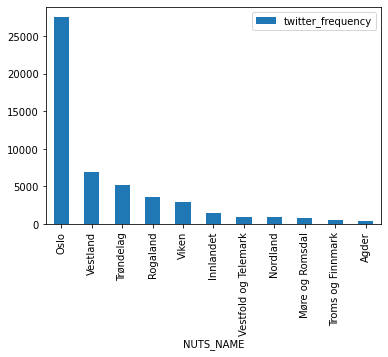

In [26]:
gdf_frequency_county = gdf_frequency_county[
    [
        'twitter_frequency'
    ]
]

gdf_frequency_county.sort_values(
    'twitter_frequency',
    ascending=False
).plot.bar()

(3.170177946244468, 32.50127274673645, 57.2991752044739, 71.84535157228288)

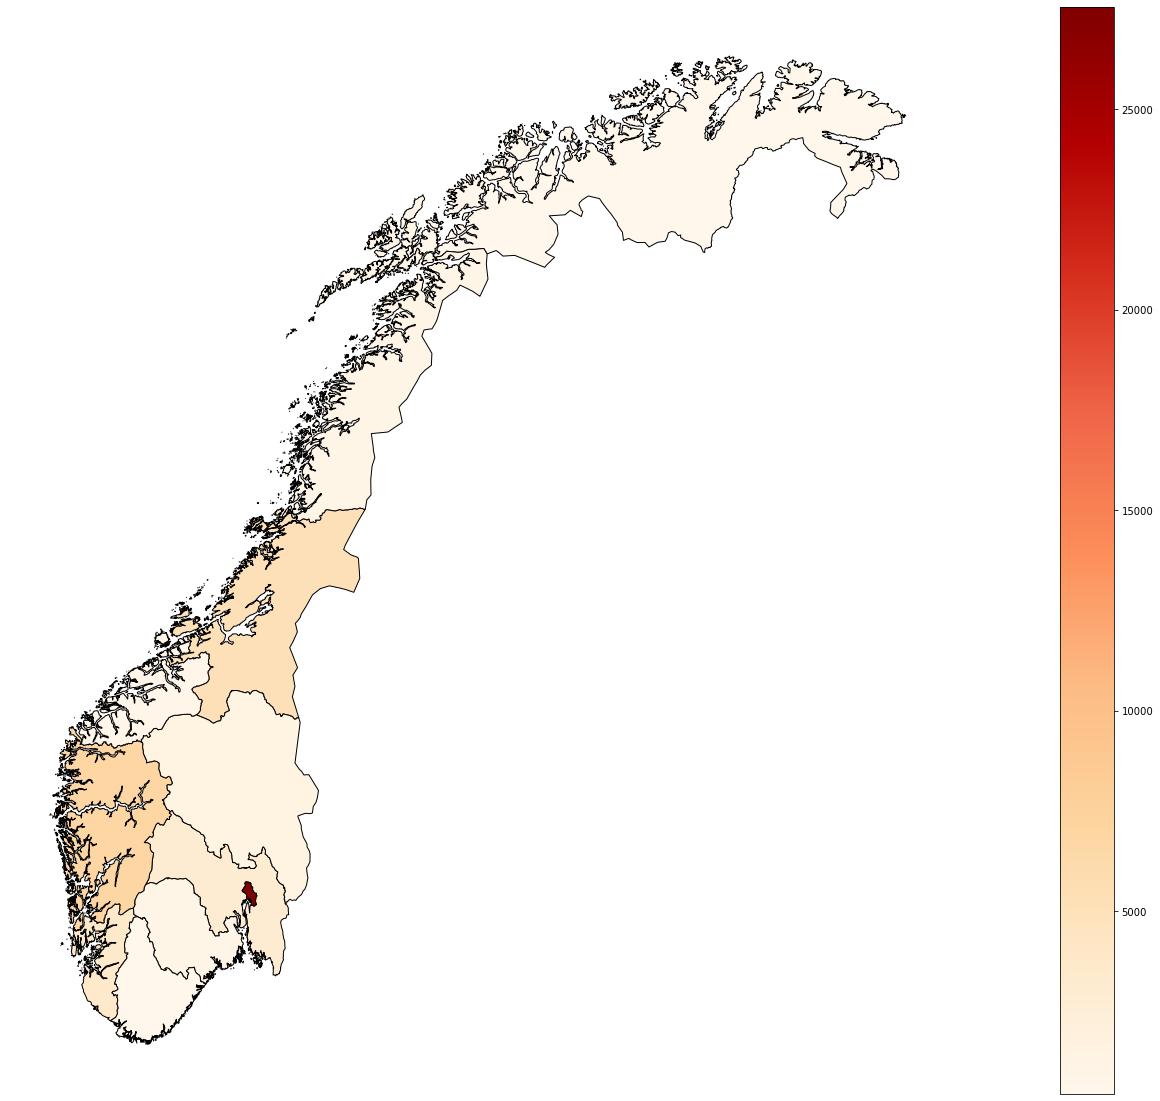

In [27]:
# Add the twitter frequency to the initial shapefile
gdf_plot = gdf_NOnuts3.merge(
    gdf_frequency_county,
    left_on = 'NUTS_NAME',
    right_on = 'NUTS_NAME'
)

# Plot the results
gdf_plot.plot(
    "twitter_frequency",
    legend = True,
    edgecolor = 'black',
    figsize = (40,20),
    cmap ='OrRd'
)
plt.axis('off')

In [189]:
test = gdf_twitter.copy()
test = test.drop(columns={'like_count','quote_count','username','text','Unnamed: 0'})

In [146]:
test = test.sjoin(
    gdf_NOnuts3, 
    how="inner", 
    predicate='intersects'
).drop(
    columns={
        'MOUNT_TYPE',
        'URBN_TYPE',
        'COAST_TYPE',
        'FID',
        'LEVL_CODE',
        'CNTR_CODE',
        'NAME_LATN'
    }
)

In [147]:
count = test.groupby('NUTS_NAME').count()

In [148]:
count

,city,created_at,latitude,longitude,label,logits0,logits1,geometry,index_right,index,NUTS_ID
NUTS_NAME,,,,,,,,,,,
Agder,447,447,447,447,447,447,447,447,447,447,447
Innlandet,1404,1404,1404,1404,1404,1404,1404,1404,1404,1404,1404
Møre og Romsdal,840,840,840,840,840,840,840,840,840,840,840
Nordland,936,936,936,936,936,936,936,936,936,936,936
Oslo,27565,27565,27565,27565,27565,27565,27565,27565,27565,27565,27565
Rogaland,3579,3579,3579,3579,3579,3579,3579,3579,3579,3579,3579
Troms og Finnmark,599,599,599,599,599,599,599,599,599,599,599
Trøndelag,5191,5191,5191,5191,5191,5191,5191,5191,5191,5191,5191
Vestfold og Telemark,962,962,962,962,962,962,962,962,962,962,962


In [149]:
total = test.groupby('NUTS_NAME').sum()

In [150]:
total

,latitude,longitude,label,logits0,logits1,index_right,index
NUTS_NAME,,,,,,,
Agder,2.606086e+04,3292.919889,348,-486.458646,460.003924,3576,363411
Innlandet,8.556519e+04,15685.334481,867,-892.238174,491.002139,7020,1045980
Møre og Romsdal,5.251072e+04,5945.639916,533,-537.294283,311.422243,7560,1260840
Nordland,6.311524e+04,13323.210989,523,-416.476707,133.846309,9360,1405872
Oslo,1.651516e+06,296031.096511,19116,-24135.414396,17438.062077,165390,21831480
Rogaland,2.113529e+05,20780.238663,2315,-2548.474318,1602.349038,3579,2569722
Troms og Finnmark,4.172381e+04,12391.499908,366,-389.474300,247.579876,2396,431879
Trøndelag,3.294957e+05,54752.956354,3737,-5437.216357,4624.901431,15573,3737520
Vestfold og Telemark,5.700937e+04,9411.269351,533,-500.126126,168.714574,6734,765752


In [151]:
new = total.copy()

In [152]:
new['negative_tweets'] = count['label'] - total['label']

In [153]:
new['non_negative_tweets'] = total['label']

In [154]:
new

,latitude,longitude,label,logits0,logits1,index_right,index,negative_tweets,non_negative_tweets
NUTS_NAME,,,,,,,,,
Agder,2.606086e+04,3292.919889,348,-486.458646,460.003924,3576,363411,99,348
Innlandet,8.556519e+04,15685.334481,867,-892.238174,491.002139,7020,1045980,537,867
Møre og Romsdal,5.251072e+04,5945.639916,533,-537.294283,311.422243,7560,1260840,307,533
Nordland,6.311524e+04,13323.210989,523,-416.476707,133.846309,9360,1405872,413,523
Oslo,1.651516e+06,296031.096511,19116,-24135.414396,17438.062077,165390,21831480,8449,19116
Rogaland,2.113529e+05,20780.238663,2315,-2548.474318,1602.349038,3579,2569722,1264,2315
Troms og Finnmark,4.172381e+04,12391.499908,366,-389.474300,247.579876,2396,431879,233,366
Trøndelag,3.294957e+05,54752.956354,3737,-5437.216357,4624.901431,15573,3737520,1454,3737
Vestfold og Telemark,5.700937e+04,9411.269351,533,-500.126126,168.714574,6734,765752,429,533


In [155]:
new = new.drop(columns={
    'latitude',
    'longitude',
    'label',
    'logits0',
    'logits1',
    'index_right',
    'index'
}
)

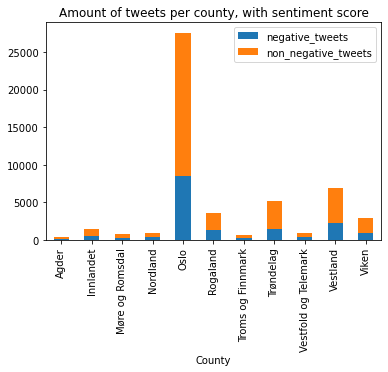

In [160]:
new.plot.bar(
    stacked=True,
    xlabel='County',
    title = 'Amount of tweets per county, with sentiment score'
)
plt.savefig('figures/tweets_per_county_sentiment.png')

In [157]:
new2 = new.copy()

In [158]:
new2['share_negative'] = new['negative_tweets']/(new['negative_tweets'] + new['non_negative_tweets'])
new2['share_non_negative'] = new['non_negative_tweets']/(new['negative_tweets'] + new['non_negative_tweets'])

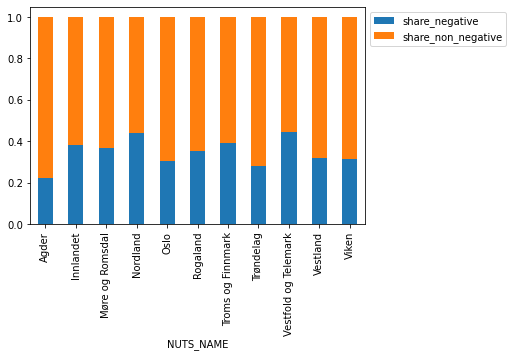

In [161]:
new2.drop(
    columns={
        'negative_tweets',
        'non_negative_tweets'
    }
).plot.bar(
    stacked=True
)
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.savefig('figures/sentiment_score_county.png')

### Temporal development per county

In [43]:
gdf_twitter_monthly_senti = gpd.GeoDataFrame(
    df_twitter,
    crs = "EPSG:4326",
    geometry=gpd.points_from_xy(df_twitter.longitude, df_twitter.latitude)
)
gdf_twitter_monthly_senti.index = gdf_twitter_monthly_senti['created_at'].dt.to_period('M')

/home/oskar/miniconda3/envs/oskar/lib/python3.10/site-packages/pandas/core/arrays/datetimes.py:1162: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


In [44]:
gdf_twitter_monthly_senti = gdf_twitter_monthly_senti.sjoin(
    gdf_NOnuts3, 
    how="inner", 
    predicate='intersects'
)

In [45]:
df_twitter_monthly_senti = pd.DataFrame(gdf_twitter_monthly_senti.drop(
    columns={
        'username',
        'like_count',
        'quote_count',
        'index',
        'LEVL_CODE',
        'CNTR_CODE',
        'NAME_LATN',
        'MOUNT_TYPE',
        'URBN_TYPE',
        'COAST_TYPE',
        'index_right',
        'text',
        'FID',
        'logits0',
        'logits1',
        'latitude',
        'longitude',
        'geometry',
        'NUTS_ID',
        'Unnamed: 0',
        'loc'
    }
))

In [46]:
df_twitter_monthly_senti

,created_at,label,NUTS_NAME
created_at,,,
2008-12,2008-12-08 07:25:53+00:00,1,Oslo
2008-09,2008-09-06 10:16:18+00:00,1,Oslo
2008-09,2008-09-03 18:58:52+00:00,1,Oslo
2008-08,2008-08-26 05:35:47+00:00,1,Oslo
2009-05,2009-05-26 15:20:20+00:00,1,Oslo
...,...,...,...
2021-12,2021-12-06 13:09:51+00:00,1,Agder
2021-12,2021-12-05 19:00:44+00:00,1,Agder
2021-12,2021-12-05 13:46:18+00:00,1,Agder


In [47]:
df_twitter_monthly_senti = df_twitter_monthly_senti.drop(columns={'created_at'})

In [48]:
df_twitter_monthly_senti

,label,NUTS_NAME
created_at,,
2008-12,1,Oslo
2008-09,1,Oslo
2008-09,1,Oslo
2008-08,1,Oslo
2009-05,1,Oslo
...,...,...
2021-12,1,Agder
2021-12,1,Agder
2021-12,1,Agder


Test case with Agder

In [49]:
dfAgder = df_twitter_monthly_senti.loc[df_twitter_monthly_senti['NUTS_NAME'] == 'Agder']

<AxesSubplot:xlabel='created_at'>

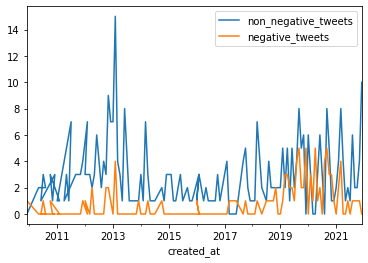

In [50]:
dfAgder.assign(
    non_negative_tweets=lambda x: x.groupby(level=0).sum()
).assign(
    amount=lambda x: x.groupby(level=0).count().label
).assign(
    negative_tweets=lambda x: x.amount - x.non_negative_tweets
).drop(columns={
    'amount',
    'label'
}
  ).plot()

In [51]:
counties = ['Agder',
            'Innlandet',
            'Møre og Romsdal',
            'Nordland',
            'Oslo',
            'Rogaland',
           'Troms og Finnmark',
            'Trøndelag',
            'Vestfold og Telemark',
            'Vestland',
            'Viken'
           ]

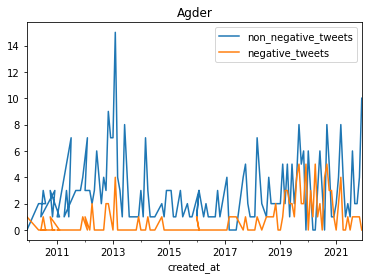

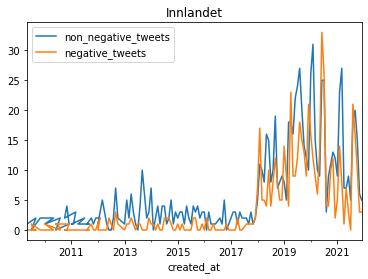

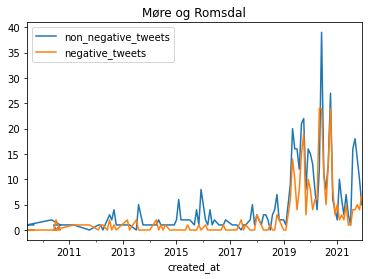

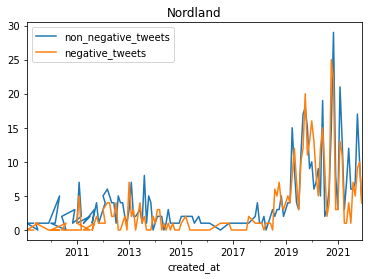

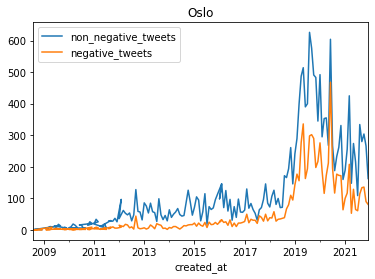

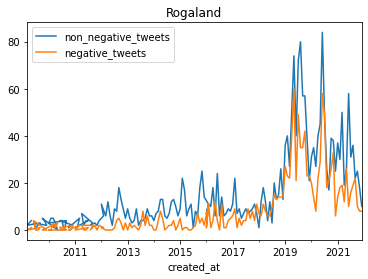

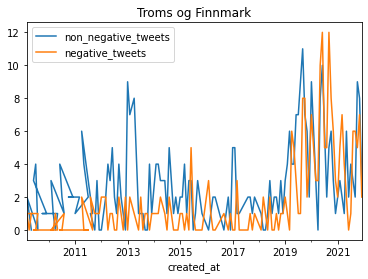

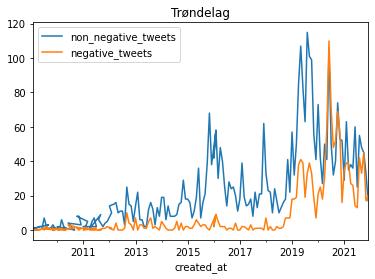

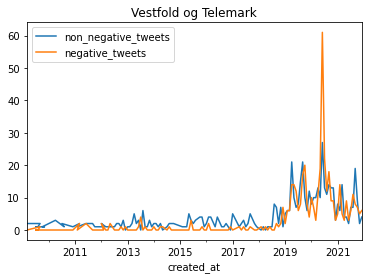

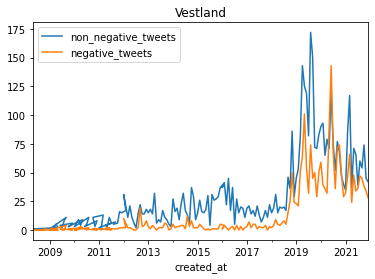

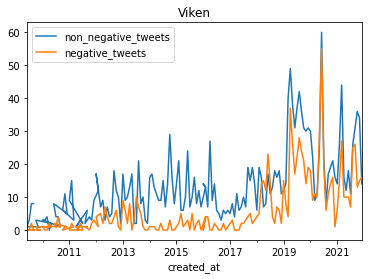

In [53]:
for county in counties:
    df_twitter_monthly_senti.loc[df_twitter_monthly_senti['NUTS_NAME'] == county].assign(
        non_negative_tweets=lambda x: x.groupby(level=0).sum()
    ).assign(
        amount=lambda x: x.groupby(level=0).count().label
    ).assign(
        negative_tweets=lambda x: x.amount - x.non_negative_tweets
    ).drop(columns={
        'amount',
        'label'
    }
      ).plot(
        title = county,
    )

## Wild testing

In [68]:
df_twitter_yearly = pd.DataFrame(df_twitter.copy())
df_twitter_yearly.index = df_twitter_yearly['created_at'].dt.to_period('Y')

/home/oskar/miniconda3/envs/oskar/lib/python3.10/site-packages/pandas/core/arrays/datetimes.py:1162: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


In [98]:
years = ['2008','2009','2010','2011','2012','2013','2014','2015','2016','2017','2018','2019','2020','2021']

In [169]:
a_list = []
for year in years:
    x = [year, df_twitter_yearly.loc[year].label.mean()]
    a_list.append(x)

In [175]:
df_year_averages = pd.DataFrame(a_list, columns=['year','share_non_negative'])

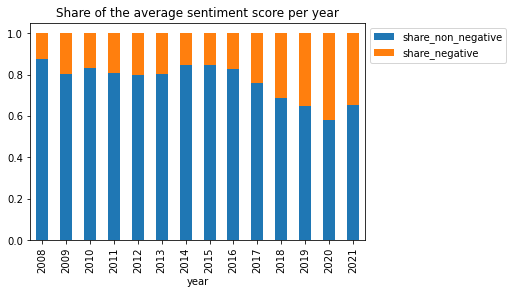

In [187]:
df_year_averages.assign(
    share_negative=lambda x: 1-x.share_non_negative
).set_index(
    'year'
).plot.bar(
    stacked=True,
    title = 'Share of the average sentiment score per year'
)
plt.legend(
    bbox_to_anchor=(
        1.0, 1.0
    )
)
plt.savefig('figures/share_negative_time')